In [2]:
import pandas as pd
import numpy as np

In [5]:
from sklearn.model_selection import cross_val_score, train_test_split

In [207]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, roc_curve, auc

In [6]:
from sklearn.linear_model import LogisticRegression

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

In [102]:
from sklearn.preprocessing import StandardScaler, Normalizer

In [34]:
from sklearn.pipeline import Pipeline

In [118]:
from sklearn.model_selection import KFold

### Домашнее задание

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?  
6. (опциональный вопрос) Найти порог классификации по деньгам (Стоимость лечения 15000 р, если сделали тест и начали лечить вовремя. Стоимость лечения 20000, если упустили и начали лечить когда уже проявились все симптомы. Стоимость теста 1400 р)

#### Подготовка датасета

In [12]:
df = pd.read_csv('train_case2.csv', sep=';' , index_col='id')

In [13]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [14]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Проверка соотношения классов для целевой переменной.

In [17]:
df['cardio'][df['cardio']==1].count()/df['cardio'][df['cardio']].count()

0.4997

Количество классов можно считать очень хорошо сбалансированным, соответственно меры по балансировке датасета в целом не трубуются.

Выделение целевой переменной и формирование датасета признаков.

In [18]:
y = df['cardio']

In [20]:
X = df.drop('cardio', axis = 1)

In [21]:
X.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
id,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1
1,20228,1,156,85.0,140,90,3,1,0,0,1
2,18857,1,165,64.0,130,70,3,1,0,0,0
3,17623,2,169,82.0,150,100,1,1,0,0,1
4,17474,1,156,56.0,100,60,1,1,0,0,0


Дальнейшая предобработка датасета и разделение его по выборкам будет осуществлятся применительно к каждой модели отдельно, т.к. разные модели могут требовать немного разную предобработку, тогда как другие (например, случайный лес), могут работать с величинами различного порядка для признаков.

Перед преобразованием проверим варианты уникальных величин в категориальных признаках и наличие пустых значений в признаках.

In [65]:
X['cholesterol'].unique()

array([1, 3, 2], dtype=int64)

In [66]:
X['gluc'].unique()

array([1, 2, 3], dtype=int64)

In [67]:
X['smoke'].unique()

array([0, 1], dtype=int64)

In [68]:
X['alco'].unique()

array([0, 1], dtype=int64)

In [69]:
X['active'].unique()

array([1, 0], dtype=int64)

In [70]:
X['gender'].unique()

array([2, 1], dtype=int64)

In [74]:
X.isna().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
dtype: int64

In [283]:
y.value_counts()

0    35021
1    34979
Name: cardio, dtype: int64

Общее количество величин различных классов достаточно неплохо сбалансировано и не требует дополнительных мероприятий по балансировке.

----------------------------
------------------------------

### Задания 1 и 2

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию

-----------------------------------------------------------------------------

#### Использование логистической регресии

Для обеспечения результатов при логистической регрессии желательно преобразование признаков разной размерности.  
В качестве метода преобразования воспользуемся стандартизацией.

In [247]:
X_log = X.copy()
X_log.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
id,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1
1,20228,1,156,85.0,140,90,3,1,0,0,1
2,18857,1,165,64.0,130,70,3,1,0,0,0
3,17623,2,169,82.0,150,100,1,1,0,0,1
4,17474,1,156,56.0,100,60,1,1,0,0,0


Применим разбиение к категориальным признакам, которые имеют значения отичные от интервала 0-1

In [253]:
X_log_gender = pd.get_dummies(X_log['gender'], prefix='gender')

In [254]:
X_log_gender.head()

,gender_1,gender_2
id,,
0,0,1
1,1,0
2,1,0
3,0,1
4,1,0


In [255]:
X_log_chol = pd.get_dummies(X_log['cholesterol'], prefix='cholesterol')

In [256]:
X_log_chol.head()

,cholesterol_1,cholesterol_2,cholesterol_3
id,,,
0,1,0,0
1,0,0,1
2,0,0,1
3,1,0,0
4,1,0,0


заменим исходные колонки на измененные признаки

In [263]:
X_log = X_log.drop('gender', axis=1).merge(X_log_gender, left_index=True, right_index=True)

In [264]:
X_log = X_log.drop('cholesterol', axis=1).merge(X_log_chol, left_index=True, right_index=True)

In [265]:
X_log.head()

,age,height,weight,ap_hi,ap_lo,gluc,smoke,alco,active,gender_1,gender_2,cholesterol_1,cholesterol_2,cholesterol_3
id,,,,,,,,,,,,,,
0,18393,168,62.0,110,80,1,0,0,1,0,1,1,0,0
1,20228,156,85.0,140,90,1,0,0,1,1,0,0,0,1
2,18857,165,64.0,130,70,1,0,0,0,1,0,0,0,1
3,17623,169,82.0,150,100,1,0,0,1,0,1,1,0,0
4,17474,156,56.0,100,60,1,0,0,0,1,0,1,0,0


Применим стандартизацию к признакам за исключением признаков с диапазоном величин 0-1.  


In [266]:
column_names = X_log.columns
column_names

Index(['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'gluc', 'smoke', 'alco',
       'active', 'gender_1', 'gender_2', 'cholesterol_1', 'cholesterol_2',
       'cholesterol_3'],
      dtype='object')

In [267]:
column_names= column_names.drop(['gluc', 'smoke', 'alco', 'active', 'gender_1', 'gender_2', 'cholesterol_1', 'cholesterol_2',
       'cholesterol_3'])
column_names

Index(['age', 'height', 'weight', 'ap_hi', 'ap_lo'], dtype='object')

In [268]:
features = X_log[column_names]

In [269]:
transformer=Normalizer().fit(features)

In [270]:
features = transformer.transform(X_log[column_names])

Проверка данных после нормализации

In [271]:
X_log[column_names] = features
X_log.head()

,age,height,weight,ap_hi,ap_lo,gluc,smoke,alco,active,gender_1,gender_2,cholesterol_1,cholesterol_2,cholesterol_3
id,,,,,,,,,,,,,,
0,0.999925,0.009133,0.003371,0.005980,0.004349,1,0,0,1,0,1,1,0,0
1,0.999928,0.007712,0.004202,0.006921,0.004449,1,0,0,1,1,0,0,0,1
2,0.999925,0.008749,0.003394,0.006893,0.003712,1,0,0,0,1,0,0,0,1
3,0.999891,0.009589,0.004653,0.008511,0.005674,1,0,0,1,0,1,1,0,0
4,0.999933,0.008927,0.003205,0.005722,0.003433,1,0,0,0,1,0,1,0,0


Разбивка датасета на тренировочную и проверочную части.

In [272]:
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y, random_state=8)

Объявление и тренировка модели логистической регрессии.  
В качестве параметра попробуем добавить L2 ругуляризацию.

In [274]:
clf_log = LogisticRegression(penalty='l2', tol=1e-5, C=0.5, random_state=17)

In [275]:
clf_log.fit(X_train_log, y_train_log)

LogisticRegression(C=0.5, random_state=17, tol=1e-05)

In [276]:
clf_log.coef_

array([[ 0.14967213, -3.08023196,  0.15968191,  2.30981602,  3.93356194,
        -0.06753384, -0.12017589, -0.13282786, -0.18765942, -0.01572017,
         0.08898821, -0.68640146, -0.02253427,  0.78220376]])

In [277]:
clf_log.score(X_train_log, y_train_log)

0.5960761904761904

Проверка качества при помощи кросс-валидации при условии использования различных метрик для оценки

In [278]:
scores_log = cross_val_score(clf_log, X_train_log, y_train, cv=5, scoring='f1_macro')

In [279]:
scores_log

array([0.57348961, 0.56896967, 0.56795088, 0.56836317, 0.55940331])

In [284]:
cv_log_f1 = scores_log.mean()
cv_log_f1

0.567635327900218

In [285]:
scores_log = cross_val_score(clf_log, X_train_log, y_train, cv=5, scoring='roc_auc')

In [286]:
scores_log

array([0.63802543, 0.64086186, 0.64687442, 0.63874566, 0.64228852])

In [287]:
cv_log_roc = scores_log.mean()
cv_log_roc

0.6413591774373848

Проводим предсказания

In [291]:
y_pred_proba_log = clf_log.predict_proba(X_test_log)

In [292]:
y_pred_proba_log

array([[0.57319806, 0.42680194],
       [0.5247303 , 0.4752697 ],
       [0.60595035, 0.39404965],
       ...,
       [0.57678037, 0.42321963],
       [0.57316041, 0.42683959],
       [0.57267742, 0.42732258]])

------------------------------------------------------------------------------

#### Использование случайного леса

In [158]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

случайный лес более устойчив к различной размерности величин и наличию категориальных переменных, поэтому оставим датасет без дополнительной предобрабюотки.

In [175]:
param_grid = {
                'n_estimators':[100, 200, 300, 500, 700, 1000],
                'criterion':['entropy'],
                'min_samples_split':[2, 10, 20],
                'min_samples_leaf':[1, 5, 10],
                'random_state':[17]}

Подготовка и разбиение датасета.

In [172]:
X_rf = X.copy()
X_rf.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
id,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1
1,20228,1,156,85.0,140,90,3,1,0,0,1
2,18857,1,165,64.0,130,70,3,1,0,0,0
3,17623,2,169,82.0,150,100,1,1,0,0,1
4,17474,1,156,56.0,100,60,1,1,0,0,0


In [173]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y, random_state=8)

Обучение модели.

Проведем перебор вариантов для определения наилучшей конфигурации эстиматора.

In [176]:
grid_clf = GridSearchCV(clf_rf, param_grid, cv=10)

In [177]:
grid_clf.fit(X_train_rf, y_train_rf)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(criterion='entropy',
                                              min_samples_leaf=5,
                                              min_samples_split=10,
                                              n_estimators=200,
                                              random_state=17),
             param_grid={'criterion': ['entropy'],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20],
                         'n_estimators': [100, 200, 300, 500, 700, 1000],
                         'random_state': [17]})

Примем лучший определенный эстиматор в качестве рабочего варианта.

In [179]:
clf_rf=grid_clf.best_estimator_

In [181]:
grid_clf.best_params_

{'criterion': 'entropy',
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 200,
 'random_state': 17}

In [182]:
grid_clf.best_score_

0.7365142857142857

Результат оценки важности признаков

In [180]:
clf_rf.feature_importances_

array([0.20886769, 0.00989482, 0.07516766, 0.10277309, 0.34725161,
       0.1544213 , 0.06989371, 0.01271771, 0.00563706, 0.00375409,
       0.00962126])

Обучим еще раз эстиматор используя тренировочный датасет и выбранные лучшие параметры.

In [184]:
%%time
clf_rf.fit(X_train_rf, y_train_rf)

Wall time: 11.7 s


RandomForestClassifier(criterion='entropy', min_samples_leaf=10,
                       n_estimators=200, random_state=17)

Оценка модели при помощи кросс-валидации на тренировочном датасете.

In [185]:
clf_rf_cv = np.mean(cross_val_score(clf_rf, X_train_rf, y_train_rf, cv=10))

In [186]:
clf_rf_cv

0.7365142857142857

Получение предсказания для выбранной модели.

In [195]:
y_pred_proba_rf = clf_rf.predict_proba(X_test_rf)

In [196]:
y_pred_proba_rf

array([[0.48746576, 0.51253424],
       [0.22571278, 0.77428722],
       [0.87769609, 0.12230391],
       ...,
       [0.66186018, 0.33813982],
       [0.89769165, 0.10230835],
       [0.57086526, 0.42913474]])

In [189]:
clf_rf.score(X_test_rf, y_test_rf)

0.7373142857142857

-------------------------------------------------------------------

#### Использование библиотеки CatBoost

In [190]:
from catboost import CatBoostClassifier

In [218]:
X_cb = X.copy()
X_cb.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
id,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1
1,20228,1,156,85.0,140,90,3,1,0,0,1
2,18857,1,165,64.0,130,70,3,1,0,0,0
3,17623,2,169,82.0,150,100,1,1,0,0,1
4,17474,1,156,56.0,100,60,1,1,0,0,0


In [219]:
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(X_cb, y, random_state=8)

Для оптимальной работы библиотеки CatBoost крайне желательно указывать список категориальных переменных.

In [220]:
cat_features = ['gender','cholesterol', 'gluc', 'smoke', 'alco', 'active']

создаем классификатор с набором гиперпараметров.

In [232]:
clf_cb = CatBoostClassifier(
    iterations=60, 
    learning_rate=0.1, 
    custom_loss=['AUC', 'Accuracy']
    #loss_function='CrossEntropy'
)

In [233]:
clf_cb.fit(X_train_cb, y_train_cb, 
        cat_features=cat_features, 
        eval_set=(X_test_cb, y_test_cb), 
        verbose=False,
        plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Получение предсказанной вероятности.

In [235]:
y_pred_proba_cb = clf_cb.predict_proba(X_test_cb)

---------------------------------------------------------------------------------------------------

### Задания 3, 4 и 5. Сводная таблица по результатам.

3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого).

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

Выведем построение ROC_AUC кривой в отдельную функцию.

In [312]:
def roc_auc_build(y, y_pred, label):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y, y_pred[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        #lw=lw #,
        label="ROC curve (area = %0.2f)" % roc_auc,
        )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC AUC кривая для модели " + label)
    plt.legend(loc="lower right")
    plt.show()
    return auc(fpr, tpr)

Подсчитаем стандартные метрики для классификации

In [313]:
# Обрабатываться будет весь массив целиком.
n=-1

##### Логистическая регрессия

In [314]:
precision_log, recall_log, thresholds_log = precision_recall_curve(y_test_log, y_pred_proba_log[:,1])

In [315]:
fscore_log = (2 * precision_log * recall_log) / (precision_log + recall_log)
ix_log = np.argmax(fscore_log)

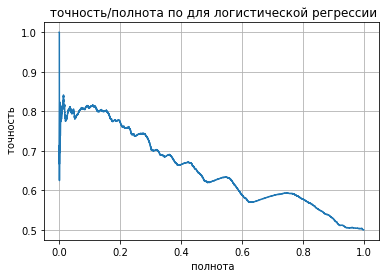

In [317]:
plt.plot(recall_log[:n],precision_log[:n] )
plt.title(' точность/полнота по для логистической регрессии')
plt.xlabel(' полнота')
plt.ylabel(' точность')
plt.grid('On')
plt.show()

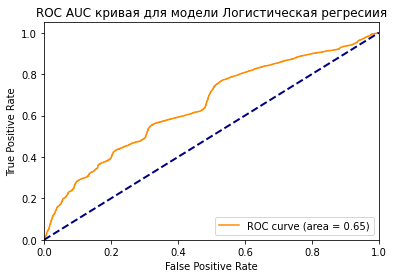

In [319]:
roc_auc_log = roc_auc_build(y_test_log, y_pred_proba_log, "Логистическая регресиия")

In [302]:
log_val = np.array([thresholds_log[ix_log], 
                      fscore_log[ix_log],
                      precision_log[ix_log],
                      recall_log[ix_log]])

##### Случайный лес

In [200]:
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test_rf, y_pred_proba_rf[:,1])

In [202]:
fscore_rf = (2 * precision_rf * recall_rf) / (precision_rf + recall_rf)
ix_rf = np.argmax(fscore_rf)

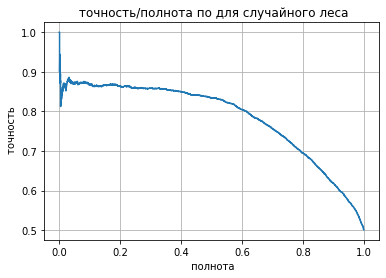

In [238]:
plt.plot(recall_rf[:n],precision_rf[:n] )
plt.title(' точность/полнота по для случайного леса')
plt.xlabel(' полнота')
plt.ylabel(' точность')
plt.grid('On')
plt.show()

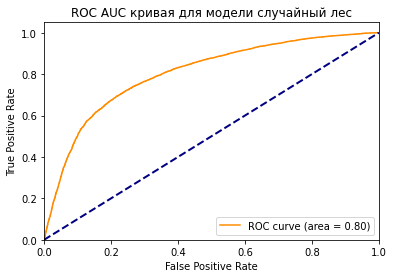

In [321]:
roc_auc_rf=roc_auc_build(y_test_rf, y_pred_proba_rf, "случайный лес")

In [322]:
rf_val = np.array([thresholds_rf[ix_rf], 
                      fscore_rf[ix_rf],
                      precision_rf[ix_rf],
                      recall_rf[ix_rf]])

#### Библиотека Cat Boost

In [236]:
precision_cb, recall_cb, thresholds_cb = precision_recall_curve(y_test_cb, y_pred_proba_cb[:,1])

In [237]:
fscore_cb = (2 * precision_cb * recall_cb) / (precision_cb + recall_cb)
ix_cb = np.argmax(fscore_cb)

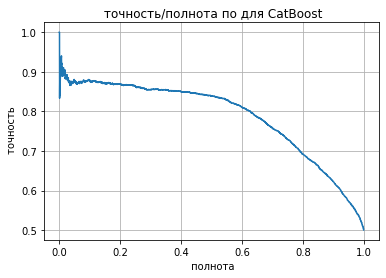

In [240]:
plt.plot(recall_cb[:n],precision_cb[:n] )
plt.title(' точность/полнота по для CatBoost')
plt.xlabel(' полнота')
plt.ylabel(' точность')
plt.grid('On')
plt.show()

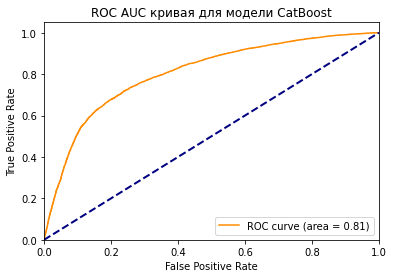

In [323]:
roc_auc_cb=roc_auc_build(y_test_cb, y_pred_proba_cb, "CatBoost")

In [324]:
cb_val = np.array([thresholds_cb[ix_cb], 
                      fscore_cb[ix_cb],
                      precision_cb[ix_cb],
                      recall_cb[ix_cb]])

Построение сводной таблицы со значениями.

In [325]:
eval_array = np.vstack((log_val, rf_val, cb_val))

In [326]:
eval_df = pd.DataFrame(eval_array, 
                       columns = ['threshold', 'fscore', 'precision', 'recall'], 
                       index=['logistic regression', 'random forest', 'cat boost'])

In [327]:
eval_df

,threshold,fscore,precision,recall
logistic regression,0.427361,0.672682,0.567216,0.826325
random forest,0.363018,0.745768,0.676690,0.830553
cat boost,0.349450,0.745400,0.669855,0.840151


In [328]:
eval_df['ROC_AUC'] = [roc_auc_log, roc_auc_rf, roc_auc_cb]

In [329]:
eval_df

,threshold,fscore,precision,recall,ROC_AUC
logistic regression,0.427361,0.672682,0.567216,0.826325,0.651551
random forest,0.363018,0.745768,0.676690,0.830553,0.803494
cat boost,0.349450,0.745400,0.669855,0.840151,0.805134


### Выводы

Как и ожидалось, простая логистическая регрессия дает наихудшие параметры финальной модели.  
Это может быть объяснено тем, что логистическая регрессия достаточно плохо работает с категориальными переменными, поэтому, в данном случае ее использование не совсем целесообразно. Также, нельзя исключать нелинейность зависимости.
высокие показатели для RandomForest вполне ожидаемы. также успешность намного выше благодаря примененному перебору метапараметров.  
Возможно, с увеличением частоты сетки или с использованием Random Search можно было подобрать еще более оптимальные параметры.
CatBoost выдал самый высокий реультат, несмотря на отсутвии подбора метапараметров и, по сути случайное их назначение. 
Из рех вариантов CatBoost, похоже, является оптимальным для данной задачи.

#### задача 5

Исходя из имеющейся информации кривая Precision-recall намного легче интерпретируется и значительно чаще используется в реальном мире.  
Но в то же время она значительно более чувствительна к дисбалансу классов.   

Также встречается мнение, что из-за немного различной методики оценки выбор конкретной метрики определяестя стоимостью ложно0положительных и ложно-отрицательных результатов для бизнеса.
Также для несбалансированных выборок можно использовать метрики обеспечивающие учет этой есбалансированности.

--------------------------------

### Задание 6

6. (опциональный вопрос) Найти порог классификации по деньгам (Стоимость лечения 15000 р, если сделали тест и начали лечить вовремя. Стоимость лечения 20000, если упустили и начали лечить когда уже проявились все симптомы. Стоимость теста 1400 р)

In [337]:
import itertools

In [338]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Построим confusion matrix для модели CatBoost, как показавшей наиболее высокий результат.

Confusion matrix, without normalization
[[5124 3624]
 [1400 7352]]


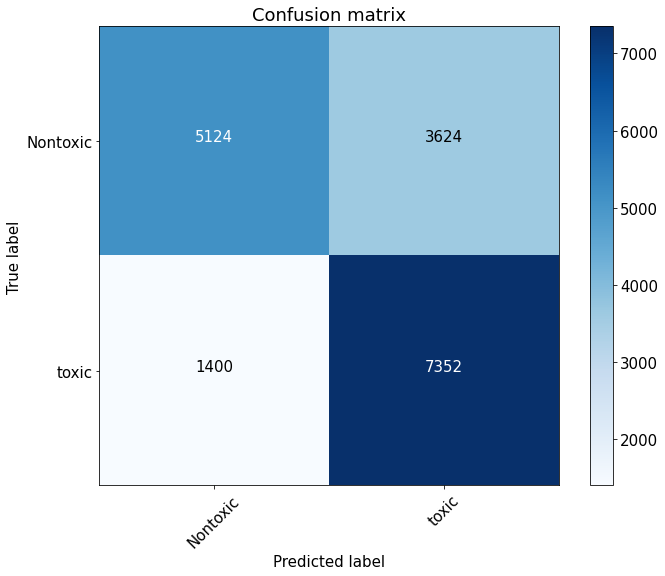

In [339]:
font = {'size' : 15}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test_cb, y_pred_proba_cb[:, 1]>thresholds_cb[ix_cb])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Nontoxic', 'toxic'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [331]:
rubl_to_test = 1400
rubl_to_early_treatment = 15000
rubl_to_late_treatment = 20000

По аналогии с занятием:

In [373]:
def business_threshold_calibrate(y_test, y_pred_proba, 
                                 thresholds, 
                                 rubl_to_test, 
                                 rubl_to_early_treatment, 
                                 rubl_to_late_treatment):
    business_threshold = 0
    r1_r2_ = 0
    r1_r3_ = 0
    r2_r3_ = 0
    rubl_1_ = - 10000000 
    rubl_all_test_ = - 10000000 
    rubl_ML_ = - 10000000 


    
    r2 = []
    n = 100
    for opt_buisness_tr in np.linspace(0,1,n).tolist():
        # подберем порог для улучшения бизнесс показателя
        # matrix is:
        # [[TP 0 0, FP 0 1]
        #  [FN 0 1, TN 1 1]
        
        cnf_matrix = confusion_matrix(y_test, y_pred_proba[:, 1] > ( opt_buisness_tr))
        
#         print(cnf_matrix[0][0])
#         print(cnf_matrix[0][1])
#         print(cnf_matrix[1][0])
#         print(cnf_matrix[1][1])
        
        # do not do anything TP + FN
        rubl_1 = ((cnf_matrix[1][1] + cnf_matrix[1][0])) * rubl_to_late_treatment

        # test all + (TP + FN) * early
        rubl_all_test = np.sum(cnf_matrix) * rubl_to_test + ((cnf_matrix[1][0]+cnf_matrix[1][1])) * rubl_to_early_treatment

        #Use ML predictions for test: (TP + FP) * test + (TP)*early + FN * late
        rubl_ML = ((cnf_matrix[1][1] + cnf_matrix[0][1])) * rubl_to_test + \
            cnf_matrix[1][1] * rubl_to_early_treatment + \
            cnf_matrix[1][0] * rubl_to_late_treatment 
       
        # cost save if apply test for ML predicted only
        r2_r3 = rubl_all_test - rubl_ML 
        
        # costs save if test evereone
        r1_r2 = rubl_1 - rubl_all_test
        
        #cost save if use ML comparing do nothing
        r1_r3 = rubl_1 - rubl_ML

        if (r2_r3_ < r2_r3):
            business_threshold = opt_buisness_tr
            r1_r2_ = r1_r2
            r1_r3_ = r1_r3
            r2_r3_ = r2_r3
            rubl_1_ = rubl_1
            rubl_all_test_ = rubl_all_test
            rubl_ML_ = rubl_ML
            
        r2.append(r2_r3)   
            
    
    print('Расходы, если не делать тест и ждать симптомов:                    ',rubl_1_)
    print('Расходы, если делать тест всем и лечить группу больных:            ',rubl_all_test_)
    print('Расходы, если не делать тест и ждать симптомов:                    ',rubl_ML_)
    print('Расходы при решении не делать тесты - расходы с МL :               ',r1_r3_ )
    print('Расходы при решении не делать тесты - расходы сделать тесты всем  :',r1_r2_ )
    print('Расходы сделать тесты всем - решение делать тесты ML  :            ',r2_r3_ )
    plt.plot(np.linspace(0,1,n),r2)
    plt.show()
    
    return business_threshold
    

Расходы, если не делать тест и ждать симптомов:                     175040000
Расходы, если делать тест всем и лечить группу больных:             155780000
Расходы, если не делать тест и ждать симптомов:                     153365600
Расходы при решении не делать тесты - расходы с МL :                21674400
Расходы при решении не делать тесты - расходы сделать тесты всем  : 19260000
Расходы сделать тесты всем - решение делать тесты ML  :             2414400


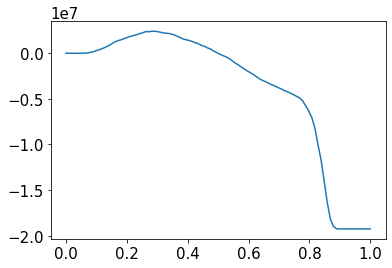

уровень порога по бизнес метрике 0.2828282828282829
уровень порога по f1 метрике 0.3494497514772689


In [374]:
BUisnes_tr = business_threshold_calibrate(y_test_cb, y_pred_proba_cb, 
                                          thresholds_cb[ix_cb] ,
                                          rubl_to_test = 1400, 
                                          rubl_to_early_treatment = 15000, 
                                          rubl_to_late_treatment = 20000)
print('уровень порога по бизнес метрике',BUisnes_tr)
print('уровень порога по f1 метрике',thresholds_cb[ix_cb])